In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from einops.layers.torch import Rearrange

from timm.data.transforms_factory import create_transform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from eyes.models.resnet import resnet18, resnet34
from eyes.trainer import train, test

from PIL import Image

%matplotlib inline

## Dealing with data

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
rand_gen = torch.manual_seed(0)
labeled_datafolder = "/home/dima/datasets/eyes/labeled/"
datafolder = "/home/dima/datasets/eyes/train/"
mrl_datafolder = "/home/dima/datasets/eyes/mrl/"
checkpoint_path = "/home/dima/eyes/checkpoints/"

In [3]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    create_transform(24, is_training=True, auto_augment='rand-m8-n3', mean=(0.5,), std=(0.5,),),
])
test_transform = transforms.Compose([
    transforms.Grayscale(),
    create_transform(24, is_training=False, mean=(0.5,), std=(0.5,),),
])

/home/dima/.cache/pypoetry/virtualenvs/eyes-l4De5T6N-py3.8/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Let's look at the MRL data

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/home/dima/.cache/pypoetry/virtualenvs/eyes-l4De5T6N-py3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:386: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


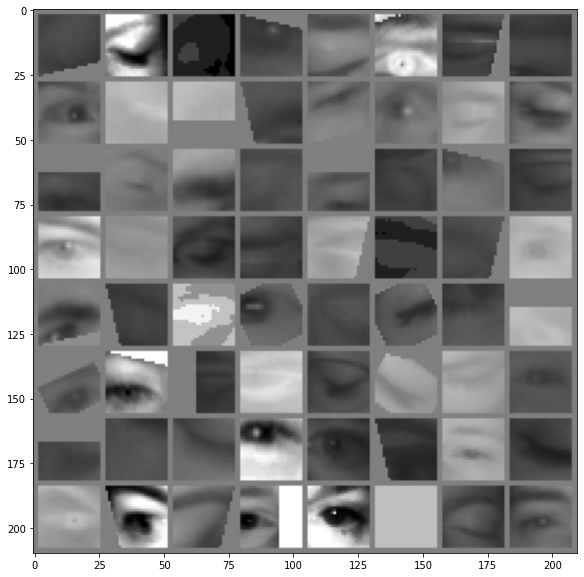

In [5]:
batch_size = 64
mrl_dataset = ImageFolder(mrl_datafolder, transform=train_transform)
train_size = int(len(mrl_dataset) * 0.9)
train_mrl_dataset, test_mrl_dataset = random_split(mrl_dataset, [train_size, len(mrl_dataset) - train_size])
trainloader = DataLoader(train_mrl_dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

## Training

In [6]:
batch_size = 512
mrl_dataset = ImageFolder(mrl_datafolder, transform=train_transform)
train_size = int(len(mrl_dataset) * 0.9)
train_mrl_dataset, test_mrl_dataset = random_split(mrl_dataset, [train_size, len(mrl_dataset) - train_size])
trainloader = DataLoader(train_mrl_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_mrl_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = resnet18().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
train(model, trainloader, optimizer, criterion, max_epochs=5)

/home/dima/.cache/pypoetry/virtualenvs/eyes-l4De5T6N-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10] loss: 0.770 acc: 0.587
[1,    20] loss: 0.636 acc: 0.648
[1,    30] loss: 0.599 acc: 0.677
[1,    40] loss: 0.575 acc: 0.688
[1,    50] loss: 0.552 acc: 0.708
[1,    60] loss: 0.517 acc: 0.725
[1,    70] loss: 0.500 acc: 0.742
[1,    80] loss: 0.510 acc: 0.730
[1,    90] loss: 0.485 acc: 0.741
[1,   100] loss: 0.444 acc: 0.778
[1,   110] loss: 0.449 acc: 0.775
[2,    10] loss: 0.448 acc: 0.774
[2,    20] loss: 0.438 acc: 0.781
[2,    30] loss: 0.416 acc: 0.799
[2,    40] loss: 0.418 acc: 0.796
[2,    50] loss: 0.397 acc: 0.798
[2,    60] loss: 0.394 acc: 0.806
[2,    70] loss: 0.394 acc: 0.807
[2,    80] loss: 0.387 acc: 0.812
[2,    90] loss: 0.385 acc: 0.813
[2,   100] loss: 0.367 acc: 0.822
[2,   110] loss: 0.380 acc: 0.816
[3,    10] loss: 0.371 acc: 0.822
[3,    20] loss: 0.380 acc: 0.816
[3,    30] loss: 0.355 acc: 0.834
[3,    40] loss: 0.347 acc: 0.844
[3,    50] loss: 0.345 acc: 0.839
[3,    60] loss: 0.363 acc: 0.827
[3,    70] loss: 0.349 acc: 0.837
[3,    80] los

Test on validation set from MRL

In [9]:
test(model, testloader, criterion)

Loss: 0.310 Acc: 0.854


Test on labeled part of original dataset

In [10]:
labeled_dataset = ImageFolder(labeled_datafolder, transform=test_transform)
labeled_dataloader = DataLoader(labeled_dataset, batch_size=100, shuffle=False)
test(model, labeled_dataloader, criterion)

Loss: 0.221 Acc: 0.927


In [13]:
torch.save(model.state_dict(), os.path.join(checkpoint_path, "resnet18_93.pt"))

## Fine-tuning

In [40]:
model = resnet18().to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_path, "resnet18_93.pt")))
for param in list(model.parameters())[:-14]:
    param.requires_grad = False

In [41]:
labeled_dataset = ImageFolder(labeled_datafolder, transform=test_transform)
labeled_train, labeled_test = random_split(labeled_dataset, [800, 200])
labeled_trainloader = DataLoader(labeled_train, batch_size=100, shuffle=True)
labeled_testloader = DataLoader(labeled_test, batch_size=100, shuffle=False)

optimizer = optim.AdamW(list(model.parameters()), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [42]:
train(model, labeled_trainloader, optimizer, criterion, max_epochs=6, print_every_k_step=8)

[1,     8] loss: 0.254 acc: 0.914
[2,     8] loss: 0.198 acc: 0.927
[3,     8] loss: 0.138 acc: 0.954
[4,     8] loss: 0.120 acc: 0.955
[5,     8] loss: 0.082 acc: 0.974
[6,     8] loss: 0.051 acc: 0.985
Finished Training


In [43]:
test(model, labeled_testloader, criterion)

Loss: 0.193 Acc: 0.940


## Final model

In [44]:
model = resnet18().to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_path, "resnet18_93.pt")))
for param in list(model.parameters())[:-14]:
    param.requires_grad = False

Fine-tune on the full dataset

In [45]:
labeled_dataset = ImageFolder(labeled_datafolder, transform=test_transform)
labeled_loader = DataLoader(labeled_dataset, batch_size=100, shuffle=True)

optimizer = optim.AdamW(list(model.parameters()), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [46]:
train(model, labeled_loader, optimizer, criterion, max_epochs=6, print_every_k_step=10)

[1,    10] loss: 0.233 acc: 0.908
[2,    10] loss: 0.167 acc: 0.938
[3,    10] loss: 0.149 acc: 0.943
[4,    10] loss: 0.117 acc: 0.957
[5,    10] loss: 0.094 acc: 0.965
[6,    10] loss: 0.060 acc: 0.978
Finished Training


In [47]:
torch.save(model.state_dict(), os.path.join(checkpoint_path, "final.pt"))